Data Description

- id: unique id for a news article
- title: the title of a news article
- author: author of the news article
- text: the text of the article; could be incomplete
- label: a label that marks the article as potentially unreliable
    - 1: unreliable
    - 0: reliable

## Importing dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Basic libraries
import pandas as pd 
import numpy as np 

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Machine Learning libraries
import sklearn 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
 

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Miscellanous libraries
from collections import Counter

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Deep learning libraries
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [7]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fake news classifcation/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fake news classifcation/data/test.csv")
test_label = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Fake news classifcation/data/submit.csv")

test["label"] = test_label["label"]

df = pd.concat([train, test])
df.shape

(26000, 5)

In [8]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [9]:
df["news"] = df["title"] +" "+ df["author"]+ " " + df["text"]
df = df.drop(['id','title','author','text'], axis=1)

In [10]:
df.head()

,label,news
0,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,1,Why the Truth Might Get You Fired Consortiumne...
3,1,15 Civilians Killed In Single US Airstrike Hav...
4,1,Iranian woman jailed for fictional unpublished...


In [11]:
#Creating a copy 
clean_df = df.copy()

def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

clean_df['news']=clean_df['news'].apply(lambda x:review_cleaning(x))

In [16]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
clean_df['news'] = clean_df['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [18]:
clean_df.head()

,label,news
0,1,house dem aide didn’t even see comey’s letter ...
1,0,flynn hillary clinton big woman campus breitba...
2,1,truth might get fired consortiumnewscom truth ...
3,1,civilians killed single us airstrike identifie...
4,1,iranian woman jailed fictional unpublished sto...


In [19]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(clean_df['news'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df1.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in news')

said 96779
mr 82937
trump 68335
one 44231
would 43770
new 43172
people 41895
like 30768
clinton 30526
it 29519
also 29446
us 28939
president 28802
time 24028
state 22926
could 22800
many 22498
even 21969
years 21134
states 20574


In [20]:
#Function to get top bigram words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_bigram(clean_df['news'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)
    
#Creating the dataframe of word and frequency
df3 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df3.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in news')

mr trump 21615
new york 17468
united states 14648
donald trump 11497
york times 10418
hillary clinton 9795
white house 7286
mrs clinton 5130
we re 5074
you re 4196
last year 4125
they re 4101
said mr 3330
mr obama 3164
president trump 3012
last week 2818
islamic state 2793
years ago 2787
obama administration 2529
president obama 2514


In [21]:
#Function to get top trigram words
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_trigram(clean_df['news'], 20)

#Printing word and their respective frequencies
for word, freq in common_words:
    print(word, freq)

#Creating a dataframe with words and count
df6 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Grouping the words and plotting their frequencies
df6.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in news')

new york times 10415
president donald trump 1494
mr trump said 1311
new york city 1199
president barack obama 851
affordable care act 745
president united states 695
director james comey 665
said mr trump 664
world war ii 609
fbi director james 570
president vladimir putin 538
black lives matter 497
national security adviser 476
democratic national committee 467
wall street journal 451
dakota access pipeline 427
breitbart news daily 409
president george bush 403
mr trump campaign 396


In [22]:
#Extracting 'reviews' for processing
news_features=clean_df.copy()
news_features=news_features[['news']].reset_index(drop=True)
news_features.head()

,news
0,house dem aide didn’t even see comey’s letter ...
1,flynn hillary clinton big woman campus breitba...
2,truth might get fired consortiumnewscom truth ...
3,civilians killed single us airstrike identifie...
4,iranian woman jailed fictional unpublished sto...


In [23]:
stop_words = set(stopwords.words("english"))
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['news'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news)  

In [24]:
corpus[1]

'flynn hillari clinton big woman campu breitbart daniel j flynn ever get feel life circl roundabout rather head straight line toward intend destin hillari clinton remain big woman campu leafi liber wellesley massachusett everywher els vote like inaugur dress remaind day way miss havisham forev wore wed dress speak great expect hillari rodham overflow year ago first address wellesley graduat class presid colleg inform gather student need debat far could ascertain spokesman kind like democrat primari minu term unknown even seven sister school glad miss adam made clear speak today us us miss rodham told classmat appoint edger bergen charli mccarthi mortim snerd attend bespectacl granni glass award matronli wisdom least john lennon wisdom took issu previou speaker despit becom first win elect seat u senat sinc reconstruct edward brook came critic call empathi goal protestor critic tactic though clinton senior thesi saul alinski lament black power demagogu elitist arrog repress intoler with

In [25]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(news_features['news'])
X.shape

(26000, 5000)

In [26]:
#Getting the target variable
y=clean_df['label']

In [27]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## Model Building: Fake News Classifier

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###  Model Selection

First select the best peforming model by using cross validaton. Let's consider all the classification algorithm and perform the model selection process

Note: I'm not including SVM in this algorithm because it took alot of time to train in my device

In [29]:
#creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
nb_cv=MultinomialNB(alpha=0.1) 
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,nb_cv]

#Printing the accuracy
for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.8829615384615386
Decision Tree Test Accuracy: 0.8393461538461539
KNN Test Accuracy: 0.6543846153846153
Naive Bayes Test Accuracy: 0.8718846153846155


From the results, we can see logistic regression outdone the rest of the algorithms followed by Naive Bayes and Decision Tree.That's great. So let's go with logistic regression with hyperparameter tuning.

### Logistic Regression with Hyperparameter Tuning
We use regularization parameter and penality for parameter tuning. let's see which one to plug.

In [30]:
param_grid = {'C': np.logspace(-4, 4, 50),
              'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=1.2067926406393288, random_state=0)
The mean accuracy of the model is: 0.8846153846153846


From the selected params, we get accuracy. Let's plug and chug

In [31]:
logreg = LogisticRegression(C=1.2067926406393288, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.88


We have got 98% accuracy. As already discussed before this is a biased dataset and we can easily get such higher accuracy without any effort in processing it. But for classification problems we need to get confusion matrix and check f1 score rather than accuracy

### Confusion Matrix
Let's look at the true positive and true negative classified by the model

Confusion matrix, without normalization


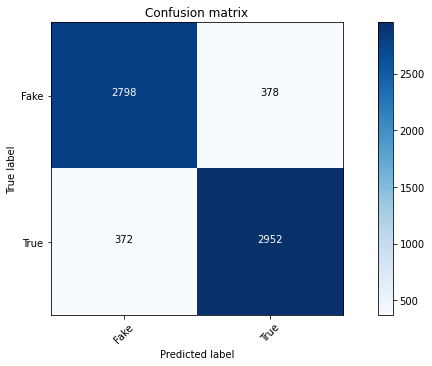

In [32]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Fake','True'])

### Classification Report
Considering Fake news, we should seriously consider precision score (False positive). We can't afford the mistakes when the model classifies fake news as true which will lead to chaos

In [33]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      3176
           1       0.89      0.89      0.89      3324

    accuracy                           0.88      6500
   macro avg       0.88      0.88      0.88      6500
weighted avg       0.88      0.88      0.88      6500



### ROC-AUC Curve
This is a very important curve where we decide on which threshold to setup based upon the objective criteria

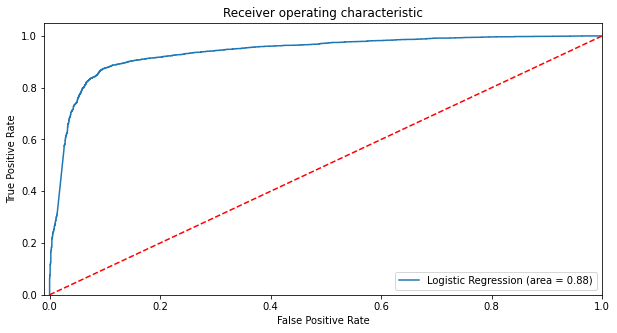

In [34]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Deep learning-LSTM
Here in this part we use neural network to predict whether the given news is fake or not.

We aren't gonna use normal neural network like ANN to clasify but LSTM(long short term memory) which helps in containing sequence information.Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. This is a behavior required in complex problem domains like machine translation, speech recognition, and more.

### One hot for Embedding layers
Before jumping into creating a layer let's take some vocabulary size. There might be a question why vocabulary size ? it is because we will be one hot encoding the sentences in the corpus for embedding layers. While onehot encoding the words in sentences will take the index from the vocabulary size. Let's fix the vocabulary size to 10000

In [ ]:
#Setting up vocabulary size
voc_size=10000

#One hot encoding 
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

### Padding embedded documents
All the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for our LSTM model, not all the sentences have the same length. In other words, naturally, some of the sentences are longer or shorter. We need to have the inputs with the same size, this is where the padding is necessary. Here we take the common length as 5000 and perform padding using pad_sequence() function . Also we are going to 'pre' pad so that zeros are added before the sentences to make the sentence of equal length

In [41]:
#Setting sentence length
sent_length=5000

#Padding the sentences
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 8098  830   18]
 [   0    0    0 ... 6643 3589 9039]
 [   0    0    0 ... 1297 3228 9759]
 ...
 [   0    0    0 ... 8555 4952 5904]
 [   0    0    0 ...    0    0  905]
 [   0    0    0 ... 3291 7907 3296]]


In [42]:
embedded_docs[1]

array([   0,    0,    0, ..., 6643, 3589, 9039], dtype=int32)

## LSTM Model
At first we are going to develop the base model and compile it. The first layer will be the embedding layer which has the input of vocabulary size, vector features and sentence length. Later we add 30% dropout layer to prevent overfitting and the LSTM layer which has 100 neurons in the layer.In final layer we use sigmoid activation function. Later we compile the model using adam optimizer and binary cross entropy as loss function since we have only two outputs.

To understand how LSTM works please check this link. To give a small overview on how LSTM works,it remembers only the important sequence of words and forgets the insignificant words which doesn't add value in the prediction

In [71]:
#Creating the lstm model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100)) #Adding 100 lstm neurons in the layer
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 5000, 40)          400000    
                                                                 
 dropout_8 (Dropout)         (None, 5000, 40)          0         
                                                                 
 lstm_4 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 456,501
Trainable params: 456,501
Non-trainable params: 0
_________________________________________________________________
None


In [72]:
len(embedded_docs),y.shape

(26000, (26000,))

In [73]:
# Converting the X and y as array
X_final=np.array(embedded_docs)
y_final=np.array(y)

#Check shape of X and y final
X_final.shape,y_final.shape

((26000, 5000), (26000,))

In [74]:
# Train test split of the X and y final
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Fitting with 10 epochs and 64 batch size
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
273/273 [==============================] - 72s 256ms/step - loss: 0.4527 - accuracy: 0.7893 - val_loss: 0.3598 - val_accuracy: 0.8570
Epoch 2/10
273/273 [==============================] - 70s 257ms/step - loss: 0.3170 - accuracy: 0.8842 - val_loss: 0.3743 - val_accuracy: 0.8554
Epoch 3/10
273/273 [==============================] - 70s 256ms/step - loss: 0.2873 - accuracy: 0.8975 - val_loss: 0.5058 - val_accuracy: 0.7723
Epoch 4/10
273/273 [==============================] - 70s 258ms/step - loss: 0.2884 - accuracy: 0.8951 - val_loss: 0.3714 - val_accuracy: 0.8618
Epoch 5/10
273/273 [==============================] - 71s 260ms/step - loss: 0.2538 - accuracy: 0.9139 - val_loss: 0.3835 - val_accuracy: 0.8604
Epoch 6/10
273/273 [==============================] - 70s 258ms/step - loss: 0.2247 - accuracy: 0.9258 - val_loss: 0.3989 - val_accuracy: 0.8514
Epoch 7/10
273/273 [==============================] - 69s 253ms/step - loss: 0.2699 - accuracy: 0.8965 - val_loss: 0.4058 - val_ac

In [75]:
# Predicting from test data
y_pred=model.predict(X_test)

Confusion matrix, without normalization


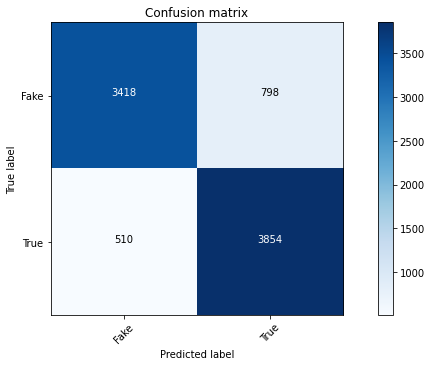

In [77]:
#Creating confusion matrix

cm = metrics.confusion_matrix(y_test, np.where(y_pred > 0.5, 1,0))
plot_confusion_matrix(cm,classes=['Fake','True'])

In [78]:
#Checking for accuracy
accuracy_score(y_test,np.where(y_pred > 0.5, 1,0))

0.8475524475524475

In [79]:
# Creating classification report 
print(classification_report(y_test,np.where(y_pred > 0.5, 1,0)))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      4216
           1       0.83      0.88      0.85      4364

    accuracy                           0.85      8580
   macro avg       0.85      0.85      0.85      8580
weighted avg       0.85      0.85      0.85      8580



## Bidirectional LSTM
Bi-LSTM is an extension of normal LSTM with two independent RNN's together. The normal LSTM is uni directional where it cannot know the future words whereas in Bi-LSTM we can predict the future use of words as there is a backward information passed on from the other RNN layer in reverse.

There is only one change made in the code compared to the LSTM, here we use Bidirectional() function and call LSTM inside.

In [80]:
# Creating bidirectional lstm model
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100))) # Bidirectional LSTM layer
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 5000, 40)          400000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              112800    
 l)                                                              
                                                                 
 dropout_10 (Dropout)        (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 513,001
Trainable params: 513,001
Non-trainable params: 0
_________________________________________________________________
None


### Fitting and Evaluation of Model
Let's now fit the bidirectional LSTM model to the data we have with the same parameters we had before

In [81]:
# Fitting the model
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
273/273 [==============================] - 209s 494ms/step - loss: 0.4608 - accuracy: 0.7881 - val_loss: 0.3645 - val_accuracy: 0.8656
Epoch 2/10
273/273 [==============================] - 132s 484ms/step - loss: 0.3512 - accuracy: 0.8716 - val_loss: 0.3588 - val_accuracy: 0.8699
Epoch 3/10
273/273 [==============================] - 133s 489ms/step - loss: 0.3057 - accuracy: 0.8930 - val_loss: 0.3759 - val_accuracy: 0.8642
Epoch 4/10
273/273 [==============================] - 133s 487ms/step - loss: 0.2756 - accuracy: 0.9056 - val_loss: 0.3648 - val_accuracy: 0.8617
Epoch 5/10
273/273 [==============================] - 131s 480ms/step - loss: 0.2519 - accuracy: 0.9148 - val_loss: 0.3960 - val_accuracy: 0.8458
Epoch 6/10
273/273 [==============================] - 128s 470ms/step - loss: 0.2801 - accuracy: 0.8980 - val_loss: 0.4004 - val_accuracy: 0.8500
Epoch 7/10
273/273 [==============================] - 131s 479ms/step - loss: 0.2620 - accuracy: 0.9064 - val_loss: 0.4128 -

Confusion matrix, without normalization


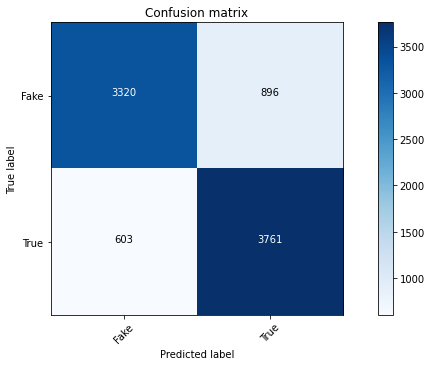

In [84]:
# Predicting from test dataset
y_pred1=model1.predict(X_test)

#Confusion matrix
cm = metrics.confusion_matrix(y_test, np.where(y_pred1 > 0.5, 1,0))
plot_confusion_matrix(cm,classes=['Fake','True'])

In [85]:
#Calculating Accuracy score
accuracy_score(y_test,np.where(y_pred1 > 0.5, 1,0))

0.8252913752913753

In [86]:
# Creating classification report 
print(classification_report(y_test,np.where(y_pred1 > 0.5, 1,0)))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      4216
           1       0.81      0.86      0.83      4364

    accuracy                           0.83      8580
   macro avg       0.83      0.82      0.82      8580
weighted avg       0.83      0.83      0.82      8580



In [ ]:
import pickle

In [ ]:
# saving the model to the local file system
filename = 'best_model.pickle'
pickle.dump(classifier, open(filename, 'wb'))